# This Jupyter Notebook goes through the different development stages of the Python Fullstack Assessment Project for Stori

## First steps:

* ### Work around Pythonic Email Delivery
* ### Work around CSV file and other data managment to create each message

## Secondary steps:

* ### Work around dockerization
* ### Work around extending the system to more than one users
* ### Work around AWS DevOps

## Pythonic Email Delivery

### Using smtplib, SSL and Gmail, emails will be sent to a given account
### The authenticaton credentials for the sender will be stored in a pickle file, which only has to be created once. 

## Pickle File for authentication credentials

### Fill the credentials dictionary, run the code once, and then erase the entries.

### This code will create a ```.pkl``` file which will contain the mailing credentials. If the file already exists, then it will load it. 

### This way, sharing code is possible without revealing personal credentials;  ```.gitignore``` already includes this ```.pkl``` file, so it's not passed onto the GitHUB repo. 

In [4]:
import pickle
import os
if not os.path.exists('secret_credentials.pkl'):
    credentials={}
    credentials['Sender Email'] = '' # sender email account
    credentials['Sender Password'] = '' # sender email account password
    with open('secret_credentials.pkl','wb') as f:
        pickle.dump(credentials, f)
else:
    credentials=pickle.load(open('secret_credentials.pkl','rb'))

## Mailing Tools and Generic Email Body.

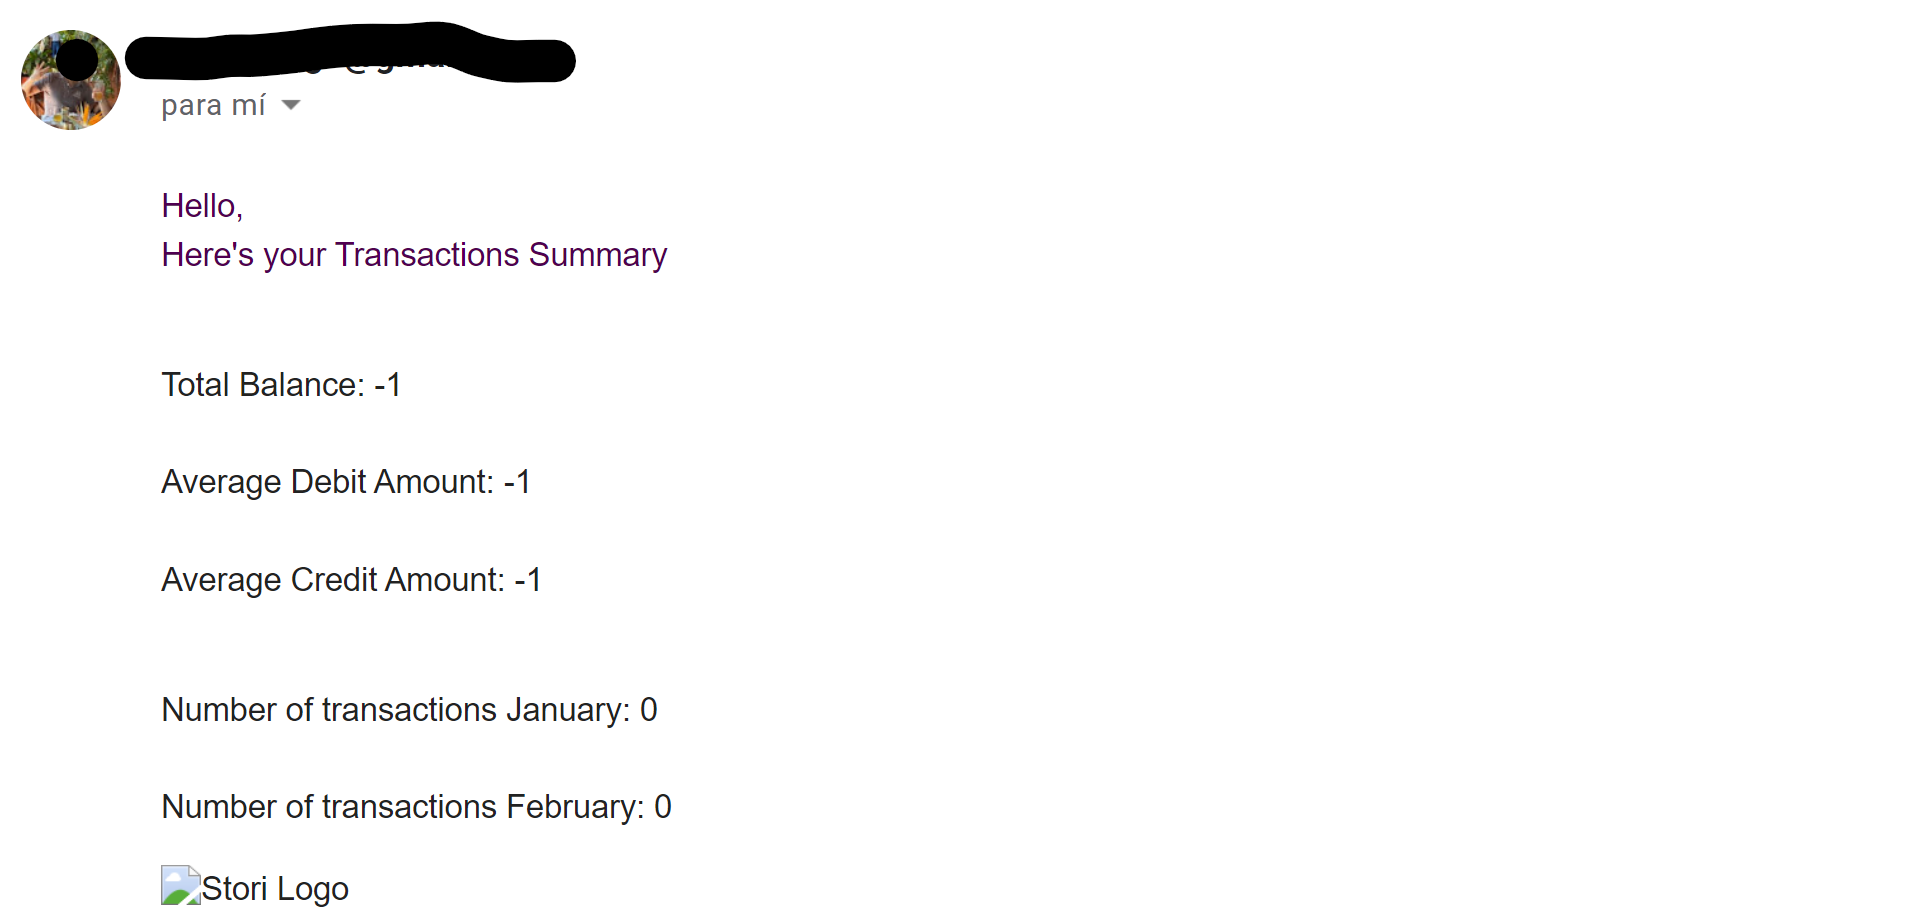

## Add Stori Logo:

![stori.jpg](attachment:stori.jpg)
                                                                                                            

In [5]:
import smtplib, ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

port = 465 # Assign 465 port for the SMTP server (Gmail's requirements)
context = ssl.create_default_context() 

In [8]:
sender_email = credentials['Sender Email']
password =credentials['Sender Password']
receiver_email = "" # receiver email account

# create Multipurpose Internet Mail Extensions object
message = MIMEMultipart("alternative")
message["Subject"] = "Transactions Summary"
message["From"] = sender_email
message["To"] = receiver_email

totalBalance = -1
avgDebit = -1
avgCredit = -1

noTransactions = {"Jan":0, "Feb":0}

html = f"""
<html>
    <body>
        <div>
            <p>Hello,<br>Here's your Transactions Summary<br>
            </p>
        </div>
        <div>
            <p>
                <br>Total Balance: {totalBalance}<br>
                <br>Average Debit Amount: {avgDebit}<br>
                <br>Average Credit Amount: {avgCredit}<br>
            </p>
            <p>
                <br>Number of transactions January: {noTransactions['Jan']}<br>
                <br>Number of transactions February: {noTransactions['Feb']}<br>
            </p>
        </div>   
    </body>
     <img align="left" width="300" hight="70" src="https://dd7tel2830j4w.cloudfront.net/f1650918197627x637468688019988200/Stori%20splash.svg" title="Stori Logo" />
</html>
"""
html_text = MIMEText(html, "html")
message.attach(html_text)

with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
    server.login(sender_email, password)
    server.sendmail(
        sender_email, receiver_email, message.as_string()
    )